# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Section 1:Business Understaning

The starbucks data give a situation about Sale Promotion with cupon. It give the customers a discount of BOGO(buy one get one free), which will prompt the sale if the customer use it. Customer get discount, starbuck get sale promotion and build customer potential consumption pattern.

For accuracy we should find out how to use the cupon:
1. Is it benifit for starbucks
2. if it worthy enough, who should we give the cupon.

# Section 2:Data Understaning

1. Reading in data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import json
import re
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

2. we will take a look at the data first.

portfolio seems no need for cleaning.

2. Data Cleaning

In [2]:
#profile['income_na'] = profile['income'].isna()
#profile['income'].fillna(0, inplace = True)

In [3]:
print(profile.shape)
profile.head(10)

(17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


In [4]:
user_id_map = pd.DataFrame(
        {'person':profile['id'],
         'person_id': range(len(profile['id']))
        })
user_id_map.head()
profile_new = profile.merge(user_id_map,how = 'left', left_on = 'id', right_on = 'person')
profile_new.drop(['id', 'person'], axis = 1, inplace = True)
profile_new.loc[profile_new['age'] >= 100 , 'age'] = np.nan

profile_new.head(10)

,gender,age,became_member_on,income,person_id
0,None,NaN,20170212,NaN,0
1,F,55.0,20170715,112000.0,1
2,None,NaN,20180712,NaN,2
3,F,75.0,20170509,100000.0,3
4,None,NaN,20170804,NaN,4
5,M,68.0,20180426,70000.0,5
6,None,NaN,20170925,NaN,6
7,None,NaN,20171002,NaN,7
8,M,65.0,20180209,53000.0,8
9,None,NaN,20161122,NaN,9


In [5]:
profile_new['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

there are a lot of customers at age 118.Those are the people who do not want to give the age informations. We will consider that as a NaN.

In [6]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [7]:
portfolio_id = portfolio['id'].unique()
offer_id = np.arange(len(portfolio_id))
offer_id_map = pd.DataFrame(
    {'portfolio_id': portfolio_id,
     'offer_id': offer_id
    })

In [8]:
offer_id_map['offer_id'].dtype

dtype('int64')

In [9]:
def clean_portfolio(portfolio = portfolio, offer_id_map = offer_id_map):
    """
    clean the portfolio data, change "ID" into "offer_id" according to offer_id_map
    split channels into columns
    
    
    """
    port_clean = portfolio.copy()
    channel_list = []
    for channel in portfolio['channels']:
        channel_list.extend(channel)
    channel_set = set(channel_list)
    
    # convert channels into dummies
    for channel in channel_set:
        port_clean['channel_' + channel] = port_clean['channels'].apply(lambda x: x.count(channel)>0)
        
    # change id according to offer_id_map
    
    port_clean['offer_id'] = port_clean['id'].apply(lambda x:
                            int(offer_id_map[offer_id_map['portfolio_id'] == x]['offer_id'].values))
        
    
    port_clean.drop(['channels','id'], axis = 1, inplace = True)
    return port_clean

clean_portfolio()

,reward,difficulty,duration,offer_type,channel_mobile,channel_email,channel_social,channel_web,offer_id
0,10,10,7,bogo,True,True,True,False,0
1,10,10,5,bogo,True,True,True,True,1
2,0,0,4,informational,True,True,False,True,2
3,5,5,7,bogo,True,True,False,True,3
4,5,20,10,discount,False,True,False,True,4
5,3,7,7,discount,True,True,True,True,5
6,2,10,10,discount,True,True,True,True,6
7,0,0,3,informational,True,True,True,False,7
8,5,5,5,bogo,True,True,True,True,8
9,2,10,7,discount,True,True,False,True,9


In [10]:
(transcript['person'].shape)

(306534,)

In [11]:
transcript['person'].nunique()

17000

In [12]:
portfolio_clean = clean_portfolio()

In [13]:
def clean_transcript(transcript = transcript, portfolio = clean_portfolio, offer_id_map = offer_id_map, user_id_map = user_id_map):
    """
    clean the transcript data, use person_id, offer_id instead of hash number.
    
    Parameters
    ------------
    
    
    Returns
    ------------
    
    
    """
    
    # simplify person to person_id
    transcript_clean = transcript.copy()    

    transcript_clean = transcript_clean.merge(user_id_map, on = 'person')    
    print(transcript_clean.event.unique())
    # 
    
    transcript_clean['portfolio_id'] = transcript_clean['value'].apply(
        lambda x : x.get('offer_id', np.nan) if (x.get('offer id', np.nan) is np.nan) else x.get('offer id', np.nan)
    )


    transcript_clean['amount'] = transcript_clean['value'].apply(lambda x :x.get('amount', np.nan))

    transcript_clean['reward'] = transcript_clean['value'].apply(lambda x :x.get('reward', np.nan))
    transcript_clean = transcript_clean.merge(offer_id_map,how = 'left', on = 'portfolio_id')
    transcript_clean['offer_id'] = transcript_clean['offer_id'].astype('Int64')
    transcript_clean.drop(['person','value', 'portfolio_id'], axis = 1, inplace = True)

    return transcript_clean

clean_trans = clean_transcript()
clean_trans.head()

['offer received' 'offer viewed' 'transaction' 'offer completed']


,event,time,person_id,amount,reward,offer_id
0,offer received,0,3,NaN,NaN,3
1,offer viewed,6,3,NaN,NaN,3
2,transaction,132,3,19.89,NaN,<NA>
3,offer completed,132,3,NaN,5.0,3
4,transaction,144,3,17.78,NaN,<NA>


In [14]:
clean_trans[clean_trans['person_id'] == 3]

,event,time,person_id,amount,reward,offer_id
0,offer received,0,3,NaN,NaN,3
1,offer viewed,6,3,NaN,NaN,3
2,transaction,132,3,19.89,NaN,<NA>
3,offer completed,132,3,NaN,5.0,3
4,transaction,144,3,17.78,NaN,<NA>
5,offer received,168,3,NaN,NaN,7
6,offer viewed,216,3,NaN,NaN,7
7,transaction,222,3,19.67,NaN,<NA>
8,transaction,240,3,29.72,NaN,<NA>
9,transaction,378,3,23.93,NaN,<NA>


In [15]:
def user_summary(data, profile = profile_new ):
    event_offer_cp = data['event'] == 'offer completed'
    event_offer_re = data['event'] == 'offer received'
    event_offer_vi = data['event'] == 'offer viewed' 
    event_offer_ta = data['event'] == 'offer transaction' 
    
    trans_offer_tag = data[data['event'].isin(['offer completed', 'transaction'])]
    time_duplicated = trans_offer_tag.duplicated(['time', 'person_id'], keep = False)
    
    # all transaction 

    # trans with out offer
    trans_without_offer_df = trans_offer_tag[~ time_duplicated]
    # trans with offer 
    trans_with_offer_df = trans_offer_tag[time_duplicated]

    
    
    # count completed offer
    offer_completed_count = data[event_offer_cp].groupby(['person_id', 'offer_id'])['person_id'].count().unstack(1)

    # count received offer
    offer_received_count = data[event_offer_re].groupby(['person_id', 'offer_id'])['person_id'].count().unstack(1)
    row = offer_received_count.index
    column = offer_received_count.columns    


    offer_viewed_count = data[event_offer_vi].groupby(['person_id', 'offer_id'])['person_id'].count().unstack(1)

    
    reward_ = data[event_offer_cp].groupby(['person_id','time'])['reward'].sum()
    reward_nozero = reward_[reward_!=0]
    mean_reward = reward_nozero.groupby(level = [0]).mean()

    # feature_matrix = offer_completed_count.merge(offer_received_count, on = 'person_id')

    
    feature_matrix = pd.DataFrame(np.nan, index = row, columns = column)
    for i in row:
        for j in column:
            try:
                if pd.isna(offer_received_count.loc[i,j]):
                    feature_matrix.loc[i,j] = np.nan
                elif pd.isna(offer_completed_count.loc[i,j]):
                    feature_matrix.loc[i,j] = 0
                else:
                    feature_matrix.loc[i,j] = 100 * offer_completed_count.loc[i,j] / offer_received_count.loc[i,j]
            except:
                feature_matrix.loc[i,j] = 0
                continue
    # feature_matrix = offer_completed_count / offer_received_count
    offer_viewed_count = offer_viewed_count.add_suffix('_viewed')
    offer_completed_count = offer_completed_count.add_suffix('_completed')
    offer_received_count = offer_received_count.add_suffix('_received')



    

    
    # get mean amount without offer
    trans_mean_without_offer = trans_without_offer_df.groupby(['person_id'])['amount'].mean()
    trans_mean_without_offer.rename('mean_trans_without_offer', inplace = True)
    
    trans_count_without_offer = trans_without_offer_df.groupby(['person_id'])['amount'].count()
    trans_count_without_offer.rename('count_trans_without_offer', inplace = True)
    
    # get mean amount with offer
    trans_mean_with_offer = trans_with_offer_df.groupby(['person_id'])['amount'].mean()
    trans_mean_with_offer.rename("mean_trans_with_offer", inplace = True)
    
    trans_count_with_offer = trans_with_offer_df.groupby(['person_id'])['amount'].count()
    trans_count_with_offer.rename('count_trans_with_offer', inplace = True)
    
#    feature_matrix = feature_matrix.merge(offer_completed_count, how = 'left', on = 'person_id')
#    feature_matrix = feature_matrix.merge(offer_received_count, how = 'left', on = 'person_id')

#    feature_matrix = feature_matrix.merge(offer_viewed_count, how = 'left', on = 'person_id')


    
    feature_matrix = feature_matrix.merge(trans_mean_without_offer, how = 'left', on = 'person_id')
    feature_matrix = feature_matrix.merge(trans_mean_with_offer,how = 'left', on = 'person_id')
    feature_matrix = feature_matrix.merge(trans_count_without_offer, how = 'left', on = 'person_id')
    feature_matrix = feature_matrix.merge(trans_count_with_offer,how = 'left', on = 'person_id')
    
    feature_matrix = feature_matrix.merge(mean_reward,how = 'left', on = 'person_id')
    feature_matrix = feature_matrix.merge(profile_new,how = 'left', on = 'person_id')
    
    feature_matrix.drop(['person_id'],axis = 1, inplace = True)
    feature_matrix['income'] = feature_matrix['income']/1000
    feature_matrix.rename(columns = {'income':'income(k)'}, inplace = True)
    return offer_completed_count, offer_received_count,offer_viewed_count, feature_matrix
#trans_feature = create_matrix(clean_trans)
c_c, r_c, v_c, summary_df = user_summary(clean_trans)



In [16]:
summary_df.head()

,0,1,2,3,4,5,6,7,8,9,mean_trans_without_offer,mean_trans_with_offer,count_trans_without_offer,count_trans_with_offer,reward,gender,age,became_member_on,income(k)
0,NaN,NaN,NaN,NaN,0.0,100.0,50.0,NaN,NaN,0.0,2.285000,2.120,8.0,1.0,5.0,None,NaN,20170212,NaN
1,NaN,NaN,0.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,26.895000,23.220,2.0,1.0,5.0,F,55.0,20170715,112.0
2,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,2.383333,NaN,6.0,NaN,NaN,None,NaN,20180712,NaN
3,100.0,NaN,NaN,100.0,NaN,NaN,NaN,0.0,100.0,NaN,23.532000,20.805,5.0,2.0,10.0,F,75.0,20170509,100.0
4,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,1.550000,NaN,3.0,NaN,NaN,None,NaN,20170804,NaN


In [17]:
summary_df[summary_df['mean_trans_with_offer'] - summary_df['mean_trans_without_offer'] > 5].describe()

,0,1,2,3,4,5,6,7,8,9,mean_trans_without_offer,mean_trans_with_offer,count_trans_without_offer,count_trans_with_offer,reward,age,became_member_on,income(k)
count,1195.000000,1182.000000,1086.0,1121.000000,1220.000000,1137.000000,1129.000000,1115.0,1108.000000,1142.000000,3055.000000,3055.000000,3055.000000,3055.000000,3055.000000,2786.000000,3.055000e+03,2788.000000
mean,61.659693,54.822335,0.0,70.621469,59.702186,77.755790,80.897549,0.0,67.208183,65.207239,11.189814,31.068849,6.657610,2.173159,5.708249,54.823403,2.016585e+07,66.526901
std,46.537344,47.910144,0.0,43.441033,47.490363,39.590019,38.003533,0.0,44.458078,45.616185,8.279014,51.007405,4.802036,1.158579,2.894562,16.915389,1.187230e+04,22.170839
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.216667,6.140000,1.000000,1.000000,2.000000,18.000000,2.013073e+07,30.000000
25%,0.000000,0.000000,0.0,0.000000,0.000000,50.000000,100.000000,0.0,0.000000,0.000000,2.983000,11.750000,3.000000,1.000000,3.500000,44.000000,2.016041e+07,50.000000
50%,100.000000,100.000000,0.0,100.000000,100.000000,100.000000,100.000000,0.0,100.000000,100.000000,10.657500,20.893333,6.000000,2.000000,5.000000,56.000000,2.017051e+07,65.000000
75%,100.000000,100.000000,0.0,100.000000,100.000000,100.000000,100.000000,0.0,100.000000,100.000000,17.500000,29.233333,9.000000,3.000000,7.333333,66.000000,2.017120e+07,82.000000
max,100.000000,100.000000,0.0,100.000000,100.000000,100.000000,100.000000,0.0,100.000000,100.000000,119.410000,1015.730000,32.000000,6.000000,25.000000,97.000000,2.018073e+07,120.000000


In [18]:
summary_df[(summary_df['count_trans_without_offer'] >= 5) & (summary_df['mean_trans_without_offer'] < 5)][[0,1,2,3,4,5,6,7,8,9]].describe()

,0,1,2,3,4,5,6,7,8,9
count,1879.000000,1870.000000,1730.0,1730.000000,1772.000000,1833.000000,1898.000000,1710.0,1768.000000,1769.000000
mean,6.714564,5.499109,0.0,30.231214,11.100451,55.091835,56.090622,0.0,33.455882,26.168268
std,23.925323,21.737933,0.0,43.951829,30.146959,48.018276,48.105764,0.0,45.037494,42.204873
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,0.000000,0.000000,0.0,0.000000,0.000000,100.000000,100.000000,0.0,0.000000,0.000000
75%,0.000000,0.000000,0.0,100.000000,0.000000,100.000000,100.000000,0.0,100.000000,50.000000
max,100.000000,100.000000,0.0,100.000000,100.000000,100.000000,100.000000,0.0,100.000000,100.000000


## 3. Explore Data

### 1. The transactions without offer

1. The overall effect of offers

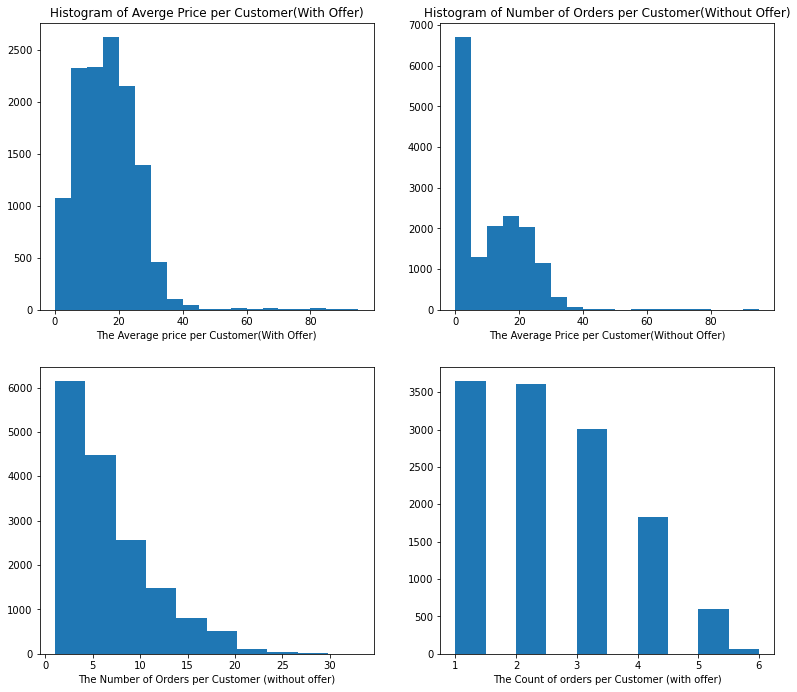

In [19]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows = 2, ncols = 2,figsize  = (12,12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax0.hist(summary_df['mean_trans_with_offer'], bins = range(0,100,5))
ax0.set_xlabel('The Average price per Customer(With Offer)')
ax0.set_title('Histogram of Averge Price per Customer(With Offer)')

ax1.hist(summary_df['mean_trans_without_offer'], bins = range(0,100,5))
ax1.set_xlabel('The Average Price per Customer(Without Offer)')
ax1.set_title('Histogram of Averge Price per Customer(Without Offer)')


ax2.hist(summary_df['count_trans_without_offer'])
ax2.set_xlabel('The Number of Orders per Customer (without offer)')
ax1.set_title('Histogram of Number of Orders per Customer(Without Offer)')

ax3.hist(summary_df['count_trans_with_offer'])
ax3.set_xlabel('The Count of orders per Customer (with offer)')
plt.show()

**With the help of offers, the average price per customer increase a lot. But we need to look deeper to get the whole picture.**

2. Will the gender affect the 

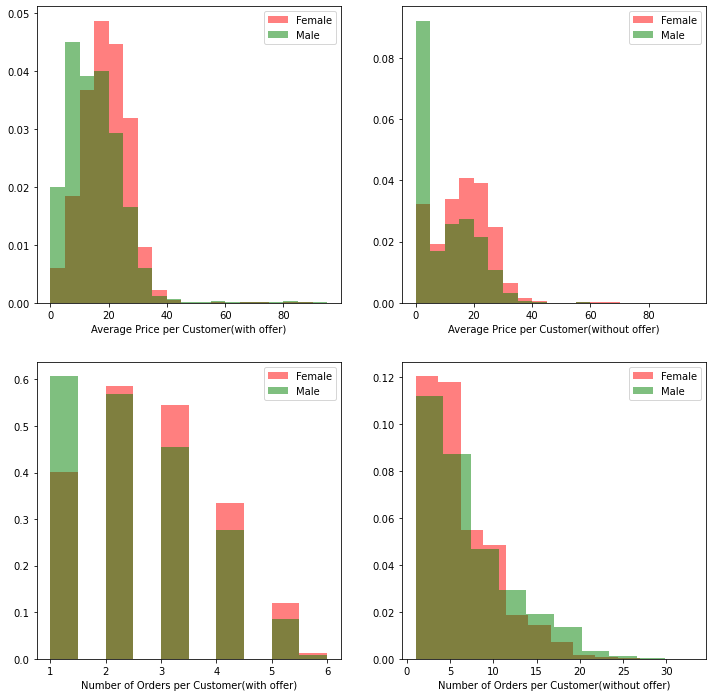

In [20]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows = 2, ncols = 2,figsize  = (12,12))

gender_mean_with_f = summary_df.loc[summary_df['gender'] == 'F', 'mean_trans_with_offer']
gender_mean_with_m = summary_df.loc[summary_df['gender'] == 'M', 'mean_trans_with_offer']
gender_mean_with_o = summary_df.loc[summary_df['gender'] == 'O', 'mean_trans_with_offer']

kwargs = dict(alpha=0.5, bins= range(0, 100, 5), density = True)

ax0.hist(gender_mean_with_f, ** kwargs, color = 'r', label = 'Female')
ax0.hist(gender_mean_with_m, ** kwargs, color = 'g', label = 'Male')
#ax0.hist(gender_mean_with_o, ** kwargs, color = 'b', label = 'O')
ax0.set_xlabel('Average Price per Customer(with offer)')
ax0.legend()

gender_mean_without_f = summary_df.loc[summary_df['gender'] == 'F', 'mean_trans_without_offer']
gender_mean_without_m = summary_df.loc[summary_df['gender'] == 'M', 'mean_trans_without_offer']
gender_mean_without_o = summary_df.loc[summary_df['gender'] == 'O', 'mean_trans_without_offer']



ax1.hist(gender_mean_without_f, ** kwargs, color = 'r', label = 'Female')
ax1.hist(gender_mean_without_m, ** kwargs, color = 'g', label = 'Male')
#ax1.hist(gender_mean_without_o, ** kwargs, color = 'b', label = 'O')
ax1.set_xlabel('Average Price per Customer(without offer)')

ax1.legend()

gender_count_with_f = summary_df.loc[summary_df['gender'] == 'F', 'count_trans_with_offer']
gender_count_with_m = summary_df.loc[summary_df['gender'] == 'M', 'count_trans_with_offer']
gender_count_with_o = summary_df.loc[summary_df['gender'] == 'O', 'count_trans_with_offer']

kwargs = dict(alpha=0.5, density = True)
ax2.hist(gender_count_with_f,  ** kwargs, color = 'r', label = 'Female')
ax2.hist(gender_count_with_m, ** kwargs, color = 'g', label = 'Male')
#ax2.hist(gender_count_with_o,  ** kwargs, color = 'b', label = 'O')
ax2.set_xlabel('Number of Orders per Customer(with offer)')

ax2.legend()

gender_count_without_f = summary_df.loc[summary_df['gender'] == 'F', 'count_trans_without_offer']
gender_count_without_m = summary_df.loc[summary_df['gender'] == 'M', 'count_trans_without_offer']
gender_count_without_o = summary_df.loc[summary_df['gender'] == 'O', 'count_trans_without_offer']

ax3.hist(gender_count_without_f, ** kwargs, color = 'r', label = 'Female')
ax3.hist(gender_count_without_m, ** kwargs, color = 'g', label = 'Male')
#ax3.hist(gender_count_without_o, ** kwargs, color = 'b', label = 'O')
ax3.set_xlabel('Number of Orders per Customer(without offer)')

ax3.legend()
plt.show()

**1. Female tend to have higher average price.**

**2. Male tend to have more orders without offer**

**3. Female tend to use offers more.**

In [ ]:
summary_df[summary_df['count_trans_without_offer'] >= 10]['mean_trans_with_offer'].hist(bins = range(0, 100, 5))

In [ ]:
summary_df['income(k)'].hist()
plt.show()
summary_df[['mean_trans_without_offer','gender']].hist(bins = range(0,100, 5))
plt.show()
summary_df['mean_trans_with_offer'].hist(bins = range(0,100, 5))
plt.show()

In [ ]:
(summary_df['mean_trans_without_offer'] *summary_df['count_trans_without_offer']).hist(bins = range(0,1000,5))

In [ ]:
summary_df['count_trans_without_offer'].hist()

In [ ]:
def create_offer_received_completed_matrix(data, profile = profile_new ):
    event_offer_cp = data['event'] == 'offer completed'
    event_offer_re = data['event'] == 'offer received'
    event_offer_vi = data['event'] == 'offer viewed' 
    event_offer_ta = data['event'] == 'offer transaction' 
    
    trans_offer_tag = data[data['event'].isin(['offer completed', 'transaction'])]
    time_duplicated = trans_offer_tag.duplicated(['time', 'person_id'], keep = False)
    
    # all transaction 

    # trans with out offer
    trans_without_offer_df = trans_offer_tag[~ time_duplicated]
    # trans with offer 
    trans_with_offer_df = trans_offer_tag[time_duplicated]

    
    
    # count completed offer
    offer_completed_count = data[event_offer_cp].groupby(['person_id', 'offer_id'])['person_id'].count().unstack(1)

    # offer_completed_count = offer_completed_count.add_suffix('_completed')
    # count received offer
    offer_received_count = data[event_offer_re].groupby(['person_id', 'offer_id'])['person_id'].count().unstack(1)


    #offer_received_count = offer_received_count.add_suffix('_received')    

    #    offer_received_count = data[event_offer_re].groupby(['person_id', 'offer_id'])['person_id'].count().unstack(1)
    # offer_received_count = offer_received_count.add_suffix('_received')    
    reward_ = data[event_offer_cp].groupby(['person_id','time'])['reward'].sum()
    reward_nozero = reward_[reward_!=0]
    mean_reward = reward_nozero.groupby(level = [0]).mean()

    # feature_matrix = offer_completed_count.merge(offer_received_count, on = 'person_id')
    row = offer_received_count.index
    column = offer_received_count.columns
    
    feature_matrix = pd.DataFrame(np.nan, index = row, columns = column)
    for i in row:
        for j in column:
            try:
                if pd.isna(offer_received_count.loc[i,j]):
                    feature_matrix.loc[i,j] = np.nan
                elif pd.isna(offer_completed_count.loc[i,j]):
                    feature_matrix.loc[i,j] = 0
                else:
                    feature_matrix.loc[i,j] = 100 * offer_completed_count.loc[i,j] / offer_received_count.loc[i,j]
            except:
                feature_matrix.loc[i,j] = 0
                continue
    # feature_matrix = offer_completed_count / offer_received_count
    

    
    # get mean amount without offer
    trans_mean_without_offer = trans_without_offer_df.groupby(['person_id'])['amount'].mean()
    trans_mean_without_offer.rename('mean_trans_without_offer', inplace = True)
    # trans_count_without_offer = trans_without_offer_df.groupby(['person_id'])['amount'].count()
    # trans_count_without_offer.rename('count_trans_without_offer')
    # get mean amount with offer
    trans_mean_with_offer = trans_with_offer_df.groupby(['person_id'])['amount'].mean()
    
    trans_mean_with_offer.rename("mean_trans_with_offer", inplace = True)
#    trans_count_with_offer = trans_with_offer_df.groupby(['person_id'])['amount'].count()
#    trans_count_with_offer.rename('count_trans_with_offer')    
    feature_matrix = feature_matrix.merge(trans_mean_without_offer, how = 'left', on = 'person_id')
    feature_matrix = feature_matrix.merge(trans_mean_with_offer,how = 'left', on = 'person_id')
    feature_matrix = feature_matrix.merge(mean_reward,how = 'left', on = 'person_id')
    feature_matrix = feature_matrix.merge(profile_new,how = 'left', on = 'person_id')
    feature_matrix.loc[feature_matrix['gender'] == 'M' , 'gender'] = 100
    feature_matrix.loc[feature_matrix['gender'] == 'F' , 'gender'] = 0
    feature_matrix.loc[feature_matrix['gender'] == 'O' , 'gender'] = 50
    feature_matrix['gender'].fillna(np.nan, inplace = True)
    feature_matrix['gender'].astype(float)
    feature_matrix.drop(['became_member_on', 'person_id'],axis = 1, inplace = True)
    feature_matrix['income'] = feature_matrix['income']/1000
    return feature_matrix
#trans_feature = create_matrix(clean_trans)
trans_df = create_offer_received_completed_matrix(clean_trans)

trans_df.head()

In [ ]:
trans_df.describe()

In [ ]:
trans_df[trans_df['mean_trans_without_offer']<= 1]

In [ ]:
trans_df['mean_trans_without_offer'].hist(bins = range(0, 100, 5))

In [ ]:
trans_mat_df = trans_df.drop([2,7],axis = 1)
trans_mat = trans_mat_df.to_numpy()
trans_mat.shape

In [ ]:
trans_mat_df_funk = trans_mat_df.drop(
    ['mean_trans_without_offer',
     'mean_trans_with_offer',
     'reward', 'gender','age',
     'income'],
    axis = 1)
trans_mat_funk = trans_mat_df_funk.to_numpy()

In [ ]:
trans_mat_df_funk.describe()

In [ ]:
def FunkSVD(trans_mat , latent_features=14, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    ratings_mat - (numpy array) a matrix with users as rows, movies as columns, and ratings as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    movie_mat - (numpy array) a latent feature by movie matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = trans_mat.shape[0] # number of rows in the matrix
    n_feature = trans_mat.shape[1] # number of movies in the matrix
    num_ratings = n_feature*n_users - np.isnan(trans_mat).sum() # total number of ratings in the matrix
    
    # initialize the user and movie matrices with random values
    # helpful link: https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.rand.html
    user_mat = np.random.rand(n_users, latent_features).astype('float64') # user matrix filled with random values of shape user x latent 
    feature_mat = np.random.rand(latent_features, n_feature).astype('float64') # movie matrix filled with random values of shape latent x movies
    print(user_mat.dtype)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # header for running results
    print("Optimization Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for i in range(iters):
        # update our sse
        sse_accum = 0.0
        max_error = 0
#        print(sse_accum.dtype)
        # For each user-movie pair
        for row in range(n_users):
            for column in range(n_feature):
                # if the rating exists
                if np.isnan(trans_mat[row,column]) ==False :
                    # compute the error as the actual minus the dot product of the user and movie latent features
                    error_mat = trans_mat[row,column] - np.dot(user_mat[row,:],feature_mat[:,column])
                    # Keep track of the total sum of squared errors for the matrix
                    if abs(error_mat) > max_error:
                        max_error = abs(error_mat)
                    
                    sse_accum += error_mat**2
                    # update the values in each matrix in the direction of the gradient
                    user_mat[row,:] +=  learning_rate*2*error_mat*feature_mat[:,column]
                    feature_mat[:,column] += + learning_rate*2*error_mat*user_mat[row,:]
                    # print results for iteration
        print('SSE for {} iter: {} {}'.format(i+1,max_error, sse_accum))


    return user_mat, feature_mat 

In [ ]:
user_mat2, feature_mat2 = FunkSVD(trans_mat,latent_features=30, learning_rate = 0.00005,iters = 100)

Funk SVD


In [ ]:
trans_mat

In [ ]:
pred = np.dot(user_mat,feature_mat)

In [ ]:
pred2 = np.dot(user_mat2,feature_mat2)
pred_df2 = pd.DataFrame(pred2, index = trans_mat_df.index, columns = trans_mat_df.columns )
pred_df2.head(10)

In [ ]:
trans_mat_df.head(10)

In [ ]:
pred_df = pd.DataFrame(pred, index = trans_mat_df_funk.index, columns = trans_mat_df_funk.columns )
pred_df.head()

In [ ]:
trans_mat_df_funk.head()

In [ ]:
trans_mat_df_funk.apply(pd.unique)